In [1]:
import networkx as nx
import numpy as np
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import copy
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Generalized Threshold Mode

In [3]:
class general_threshold():
    def __init__(self):
        self.g = nx.DiGraph()
        self.influence = None
        # threshold determine whether the node become activated
        self.threshold = None
        # spreadTrd determine whether the node have the ability to spread message
        self.spreadTrd = None
    
    def fit(self, g):
        # fit graph with probability
        in_degree = g.in_degree()
        self.num_nodes = g.number_of_nodes()
        self.node_label = [i for i in g.nodes()]
        self.label2id = {self.node_label[i]: i for i in range(self.num_nodes)}
        self.influence = np.zeros((self.num_nodes, self.num_nodes), dtype=float)
        centrality = nx.degree_centrality(g)
        # init influence
        for e in g.edges():
            self.influence[self.label2id[e[0]], self.label2id[e[1]]] = 1 / in_degree[e[1]]
        # init threshold. In GT model, the threshold of each node is assigned half of it's centrality
        self.threshold = np.zeros((self.num_nodes), dtype=float)
        self.spreadTrd = np.zeros((self.num_nodes), dtype=float)
        for n in g.nodes():
            self.threshold[self.label2id[n]] = centrality[n]/4
            self.spreadTrd[self.label2id[n]] = centrality[n]/2
        self.g = g
        return g
    
    # diffusion to all possible nodes
    def diffusion_all(self, init_seed):
        if(init_seed == []):
            return [], []
        activated_nodes = [self.label2id[name] for name in init_seed]
        old_spread_nodes = copy.deepcopy(activated_nodes)
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(old_spread_nodes)]
        while True:
            new_activated_nodes = []
            new_spread_nodes = []
            for node in old_spread_nodes:
                neighbors = self.influence[node, :].nonzero()[0]
                if(len(neighbors) == 0):
                    continue
                for neighbor in neighbors:
                    total_influence = 0.0
                    if(neighbor in activated_nodes or neighbor in new_activated_nodes):
                        continue
                    precessors = self.influence[:, neighbor].nonzero()[0]
                    for precessor in precessors :
                        if precessor in activated_nodes:
                            total_influence += self.influence[precessor][neighbor]
                    # informe/activate the node if the total influence exceeds it's threshold of activated
                    if(total_influence >= self.threshold[neighbor]):
                        new_activated_nodes.append(neighbor)
                        # let node be a spreader if the total influence exceeds it's threshold of spread
                        if(total_influence >= self.spreadTrd[neighbor]):
                            new_spread_nodes.append(neighbor)
            if len(new_spread_nodes)==0:
                break
            else:
                activated_nodes.extend(new_activated_nodes)
            old_spread_nodes = copy.deepcopy(new_spread_nodes)
            times.append(len(new_activated_nodes))
        return activated_nodes, times
    
    # diffusion to max step
    def diffusion_step(self, init_seed, max_step=1):
        if(init_seed == []):
            return [], []
        activated_nodes = [self.label2id[name] for name in init_seed]
        old_spread_nodes = copy.deepcopy(activated_nodes)
        # the index represent time t, the value is number of activated nodes in current time
        times = [len(old_spread_nodes)]
        for _ in range(max_step):
            new_activated_nodes = []
            new_spread_nodes = []
            for node in old_spread_nodes:
                neighbors = self.influence[node, :].nonzero()[0]
                if(len(neighbors) == 0):
                    continue
                for neighbor in neighbors:
                    total_influence = 0.0
                    if(neighbor in activated_nodes or neighbor in new_activated_nodes):
                        continue
                    precessors = self.influence[:, neighbor].nonzero()[0]
                    for precessor in precessors:
                        if precessor in activated_nodes:
                            total_influence += self.influence[precessor][neighbor]
                    # informe/activate the node if the total influence exceeds it's threshold of activated
                    if(total_influence >= self.threshold[neighbor]):
                        new_activated_nodes.append(neighbor)
                        # let node be a spreader if the total influence exceeds it's threshold of spread
                        if(total_influence >= self.spreadTrd[neighbor]):
                            new_spread_nodes.append(neighbor)
            if len(new_spread_nodes)==0:
                break
            else:
                activated_nodes.extend(new_activated_nodes)
            old_spread_nodes = copy.deepcopy(new_spread_nodes)
            times.append(len(new_activated_nodes))
        return activated_nodes, times
    
    

In [4]:
# read from gml
G = nx.read_gml('PB2020.gml')

In [5]:
gt_model = general_threshold()
gt_model.fit(G)

In [6]:
# init seed
N = G.number_of_nodes()
nodes = np.array(G.nodes())
ran_num = np.random.randint(low=0, high=N, size=20)
init_seed = nodes[ran_num]

activated_nodes, times = gt_model.diffusion_all(init_seed)
print(times)

[20]


In [11]:
init_seed = ['principe_giovan', 'Premises187', 'MoralDK', 'proudboy_', 'enrique_tarrio', 'GavinM_ProudBoy', 'proudboy2012']
activated_nodes, times = gt_model.diffusion_all(init_seed)
print(times)

[7, 6822, 1, 17]


In [8]:
activated_nodes, times = gt_model.diffusion_step(init_seed, 1)
print(times)

[7, 6822]


### Compare the activated nodes' number of thresholds subject to [0, 0.001] as a function of time t.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


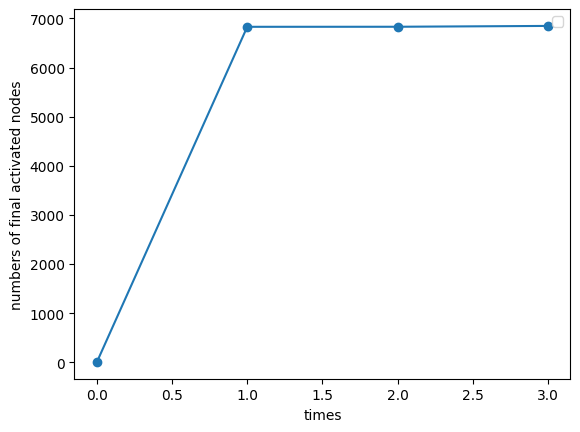

In [12]:
sum = []
s=0
for t in times:
    s=s+t
    sum.append(s)
plt.plot(np.arange(len(times)), sum, marker='o')
plt.legend()
plt.xlabel("times")
plt.ylabel("numbers of final activated nodes")
plt.show()

In [10]:
# not important here
max(G.in_degree(), key = lambda x:x[1])[1]

574